In [154]:
import sys
import os
from Args import get_notebook_args, Args
sys.path.insert(0, os.path.abspath('../..'))
from src.DataLoad import load_source_data
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from src.Epoch import train_epoch
from src.utility import precompute_gaussian_params
from src.Neural import CNF, RunningAverageMeter
from src.plot import *
from src.PreProcess import *
from src.DataLoad import *

In [155]:
def plot_embeddings(
    data_list, 
    time_labels=None, 
    colors=None, 
    figsize=(15, 20), 
    alpha=0.5, 
    title="Temporal Embedding Visualization", 
    marker='o', 
    s=30, 
    TwoDplot=True
):
    """
    Plot the temporal embeddings of the data in 2D or 3D.

    Parameters:
        data_list: list of tensors or arrays, each contains the data of a time point
        time_labels: optional, list of time point labels, default is 't0, t1, t2...'
        colors: optional, list of colors, default is the color cycle of matplotlib
        figsize: figure size, default (15, 20)
        alpha: point opacity, default 0.5
        title: figure title, default "Temporal Embedding Visualization"
        marker: scatter plot marker, default 'o'
        s: point size, default 30
        TwoDplot: if True, plot 2D; if False, plot 3D
    Returns:
        fig, ax: matplotlib figure and axis object, can be further customized
    """
    # Check the dimension of the data
    for i, data in enumerate(data_list):
        if TwoDplot:
            if data.shape[1] < 2:
                print(f" Warning: The dataset {i} is not two-dimensional. Shape: {data.shape}")
        else:
            if data.shape[1] < 3:
                print(f" Warning: The dataset {i} is not three-dimensional. Shape: {data.shape}")
    # Select the first 2 or 3 dimensions for plotting
    if TwoDplot:
        data_plot = [data[:, [1, 2]] for data in data_list]
    else:
        data_plot = [data[:, :3] for data in data_list]

    # Create default labels if not provided
    if time_labels is None:
        time_labels = [f't{i}' for i in range(len(data_list))]

    # Create default colors list if not provided
    if colors is None:
        prop_cycle = plt.rcParams['axes.prop_cycle']
        colors = prop_cycle.by_key()['color']
        if len(colors) < len(data_list):
            colors = list(mcolors.TABLEAU_COLORS.values()) * ((len(data_list) // len(mcolors.TABLEAU_COLORS)) + 1)
            colors = colors[:len(data_list)]

    # Create the figure and axis
    if TwoDplot:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111, projection='3d')

    # Plot the data for each time point
    for i, data in enumerate(data_plot):
        color_idx = i % len(colors)  # Cycle through colors if not enough
        data_np = data.detach().cpu().numpy() if hasattr(data, 'detach') else data
        if TwoDplot:
            ax.scatter(data_np[:, 0], data_np[:, 1], 
                       color=colors[color_idx], 
                       alpha=alpha, 
                       label=time_labels[i],
                       marker=marker,
                       s=s)
        else:
            ax.scatter(data_np[:, 0], data_np[:, 1], data_np[:, 2],
                       color=colors[color_idx], 
                       alpha=alpha, 
                       label=time_labels[i],
                       marker=marker,
                       s=s)

    # Add legend and labels
    ax.legend(fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Dimension 1", fontsize=12)
    ax.set_ylabel("Dimension 2", fontsize=12)
    if not TwoDplot:
        ax.set_zlabel("Dimension 3", fontsize=12)
        ax.set_box_aspect([1,1,1])  # Keep xyz aspect ratio equal
        # Optionally, you can set the view angle:
        # ax.view_init(elev=20, azim=120)
    else:
        ax.set_aspect('equal')

    return fig, ax

Default data path: ../../data/scMultiSim/FiveBranch_scRNA_pca.npz
Default time labels: ['time1', 'time2', 'time3', 'time4']
Default ot dimension: 5
Default time points: [1, 2, 3, 4]
Data type: <class 'numpy.lib.npyio.NpzFile'>
Available keys in npz file: ['time1', 'time2', 'time3', 'time4']
time point time1 data shape: torch.Size([1430, 5])
time point time2 data shape: torch.Size([1920, 5])
time point time3 data shape: torch.Size([3103, 5])
time point time4 data shape: torch.Size([3547, 5])


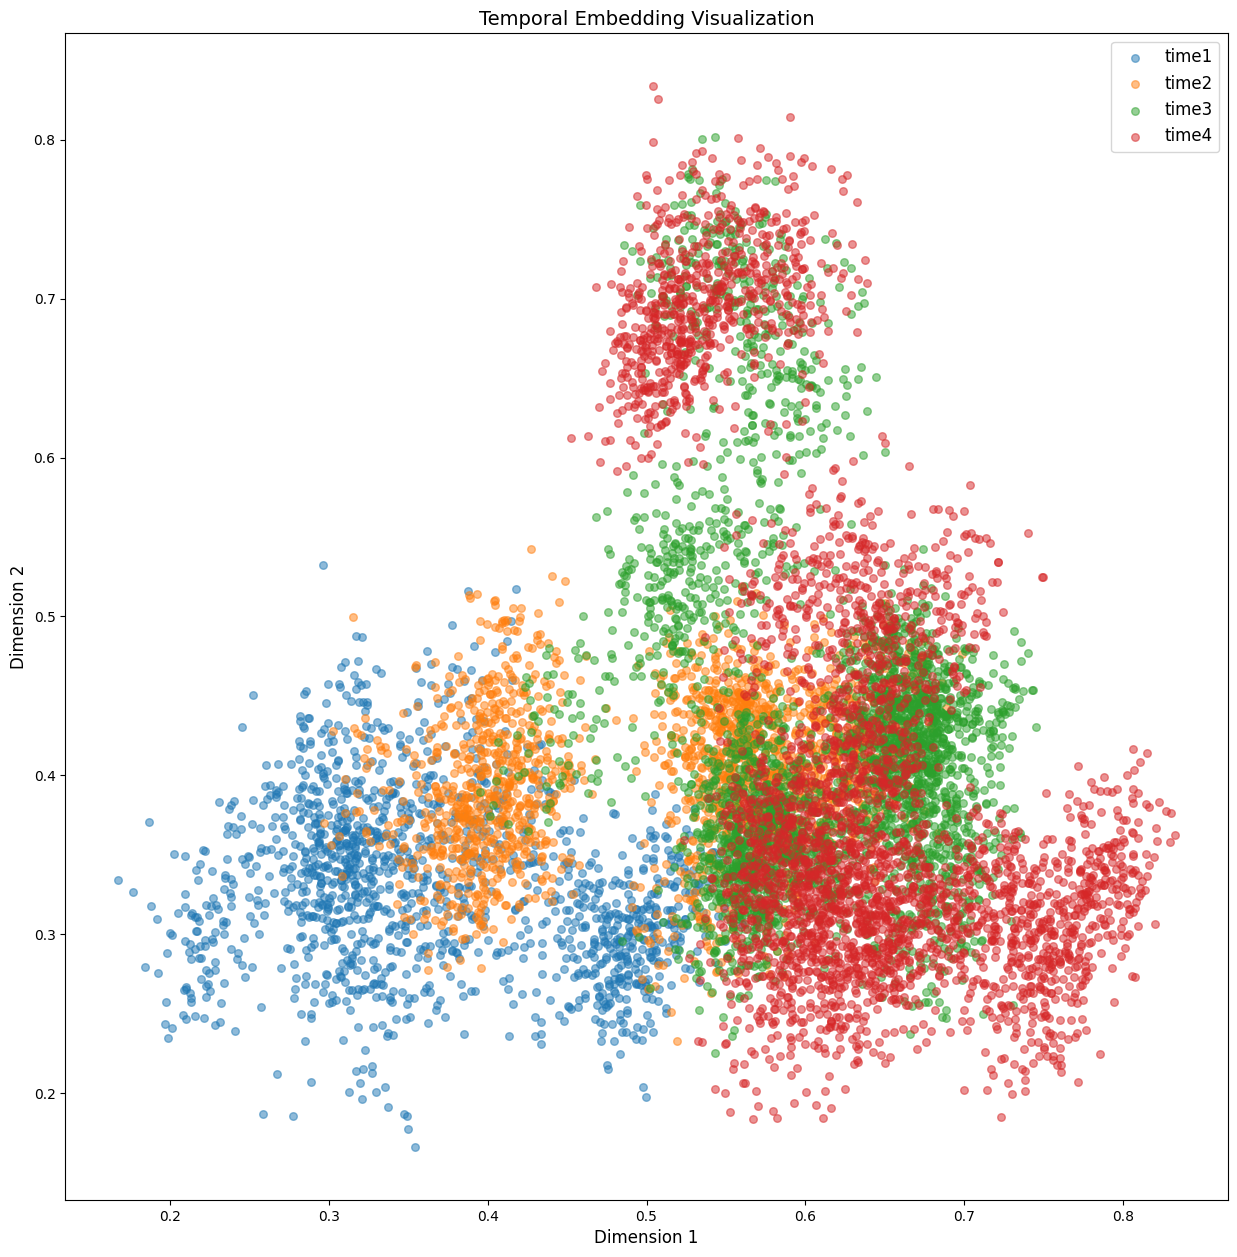

In [156]:
args = get_notebook_args()
print(f"Default data path: {args.data_path}")
print(f"Default time labels: {args.time_labels}")
print(f"Default ot dimension: {args.otdim}")
print(f"Default time points: {args.time_points}")
data_train= load_source_data(args.data_path, args.time_labels, args.support_points)


device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() and args.gpu >= 0 else 'cpu')
primary_data = [data for data in data_train] 

# record the number of samples in each group
lengths = [data.shape[0] for data in primary_data]

# concatenate and normaliz


total_primal = torch.cat(primary_data, dim=0)
total_primal, norm_params = normalize_to_unit_cube(total_primal, save_path='primal_norm_params.pt')

# split back according to the recorded lengths
split_points = torch.cumsum(torch.tensor(lengths), dim=0).tolist()
start = 0
normalized_data = []

for end in split_points:
    normalized_data.append(total_primal[start:end])
    start = end

# update primary_data to the normalized data
primary_data = normalized_data 
time_labels = args.time_labels

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() and args.gpu >= 0 else 'cpu')

fig, ax = plot_embeddings(primary_data, args.time_labels)
plt.show()

In [157]:



density_precompute_list = []
for i in range(len(args.time_points)):
    z_curr_primal = primary_data[i]
    sigma = args.sigma
    weights, means, precisions = precompute_gaussian_params(z_curr_primal, sigma, device)
    density_precompute_list.append((weights, means, precisions))
    
time_steps_list = []
for t_idx in range(len(args.time_points) - 1):
    dt = args.dt
    t0, t1 = args.time_points[t_idx], args.time_points[t_idx + 1]
    
    time_steps_short_backward = torch.linspace(t1, t0, int((t1-t0)/dt)+1).to(device)
    time_steps_short_forward = torch.linspace(t0, t1, int((t1-t0)/dt)+1).to(device)
    
    t_init = args.time_points[0]
    time_steps_long_backward = torch.linspace(t1, t_init, int((t1-t_init)/dt)+1).to(device)
    time_steps_long_forward = torch.linspace(t_init, t1, int((t1-t_init)/dt)+1).to(device)
    
    time_steps_list.append((time_steps_short_backward, time_steps_short_forward, 
                            time_steps_long_backward, time_steps_long_forward))
print(time_steps_list)

func = CNF(in_out_dim=args.otdim, hidden_dim=args.hidden_dim, n_hiddens=args.n_hiddens,activation=args.activation,  UnbalancedOT= args.UnbalancedOT).to(device)
#optimizer = optim.Adam(func.parameters(), lr=args.lr)
optimizer = optim.AdamW(
func.parameters(),
lr=args.lr,
weight_decay=0.001
)

total_steps = args.niters
gamma = (5e-6 / args.lr) ** (2.0 / total_steps) 

loss_meter = RunningAverageMeter()

scheduler = torch.optim.lr_scheduler.ExponentialLR(
    optimizer,
    gamma=gamma,
    verbose=True
)


from src.utility import load_checkpoint
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
from collections import deque
from functools import partial
from torchdiffeq import odeint
from src.DataLoad import get_exact_batch
from src.MapSpace import map_to_nearest_manifold
from PIL import Image
import glob
from collections import deque
from src.Loss import Manifold_reconstruction_loss
    
load_checkpoint(func, optimizer, scheduler, args, ckpt_path='ckpt_iter_2000.pth')

[(tensor([2.0000, 1.9500, 1.9000, 1.8500, 1.8000, 1.7500, 1.7000, 1.6500, 1.6000,
        1.5500, 1.5000, 1.4500, 1.4000, 1.3500, 1.3000, 1.2500, 1.2000, 1.1500,
        1.1000, 1.0500, 1.0000], device='cuda:0'), tensor([1.0000, 1.0500, 1.1000, 1.1500, 1.2000, 1.2500, 1.3000, 1.3500, 1.4000,
        1.4500, 1.5000, 1.5500, 1.6000, 1.6500, 1.7000, 1.7500, 1.8000, 1.8500,
        1.9000, 1.9500, 2.0000], device='cuda:0'), tensor([2.0000, 1.9500, 1.9000, 1.8500, 1.8000, 1.7500, 1.7000, 1.6500, 1.6000,
        1.5500, 1.5000, 1.4500, 1.4000, 1.3500, 1.3000, 1.2500, 1.2000, 1.1500,
        1.1000, 1.0500, 1.0000], device='cuda:0'), tensor([1.0000, 1.0500, 1.1000, 1.1500, 1.2000, 1.2500, 1.3000, 1.3500, 1.4000,
        1.4500, 1.5000, 1.5500, 1.6000, 1.6500, 1.7000, 1.7500, 1.8000, 1.8500,
        1.9000, 1.9500, 2.0000], device='cuda:0')), (tensor([3.0000, 2.9500, 2.9000, 2.8500, 2.8000, 2.7500, 2.7000, 2.6500, 2.6000,
        2.5500, 2.5000, 2.4500, 2.4000, 2.3500, 2.3000, 2.2500, 2.2000, 

/home/jfwang/miniconda3/envs/SynOT/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


2000

In [158]:

forward_index= np.arange(0, 4000)
backward_index = -forward_index

chosen_indices = np.concatenate([forward_index, backward_index])





In [159]:
viz_samples = len(chosen_indices)
viz_timesteps = 21
time_points = [4, 1]


with torch.no_grad():
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Start from t0
    z0_viz = get_batch_by_index(chosen_indices, device, primary_data[3])[0]
    #z1_viz = get_batch_by_index(chosen_indices, device, primary_data)[0]
    logp_diff_t0 = torch.zeros(viz_samples, 1).type(torch.float32).to(device)

    
    # Generate acomplete evolution trajectory
    all_samples = []
    all_times = []
    
    # Generate evolution for each adjacent time point pair
    for t_idx in range(len(time_points)-1):
        current_times = np.linspace(time_points[t_idx], time_points[t_idx+1], viz_timesteps)
        all_times.extend(current_times)
        
        if t_idx == 0:
            initial_point = (z0_viz, logp_diff_t0)
        else:
            initial_point = (z_t_samples_primal[-1], log_zt_sample[-1])
        
        z_t_samples_primal, log_zt_sample = odeint(
            func,
            initial_point,
            torch.tensor(current_times).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='rk4',
        )
        
        all_samples.append(z_t_samples_primal)

    # Concatenate all samples
    all_samples_backward = torch.cat(all_samples, dim=0)
    
    print(all_samples_backward.shape)

torch.Size([21, 8000, 5])


In [160]:
point_cloud_pairs = [
    (all_samples_backward[i], all_samples_backward[i+1])
    for i in range(len(all_samples_backward) - 1)
]
batch_losses = [torch.norm(pc1 - pc2, p=2) for pc1, pc2 in point_cloud_pairs]
#batch_losses = [w2_loss((pc1), (pc2)) for pc1, pc2 in point_cloud_pairs]
energy_loss = torch.mean(torch.stack(batch_losses))

print(energy_loss)

tensor(3.4470, device='cuda:0')


In [161]:
time_points = [1, 4]


with torch.no_grad():
    torch.manual_seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # Start from t0
    z0_viz = get_batch_by_index(chosen_indices, device, primary_data[0])[0]
    #z1_viz = get_batch_by_index(chosen_indices, device, primary_data)[0]
    logp_diff_t0 = torch.zeros(viz_samples, 1).type(torch.float32).to(device)
    g_t0 = torch.zeros(viz_samples, 1).type(torch.float32).to(device)
    
    # Generate acomplete evolution trajectory
    all_samples = []
    all_times = []
    
    # Generate evolution for each adjacent time point pair
    for t_idx in range(len(time_points)-1):
        current_times = np.linspace(time_points[t_idx], time_points[t_idx+1], viz_timesteps)
        all_times.extend(current_times)
        
        if t_idx == 0:
            initial_point = (z0_viz, logp_diff_t0)
        else:
            initial_point = (z_t_samples_primal[-1], log_zt_sample[-1])
        
        z_t_samples_primal, log_zt_sample = odeint(
            func,
            initial_point,
            torch.tensor(current_times).to(device),
            atol=1e-5,
            rtol=1e-5,
            method='rk4',
        )
        
        all_samples.append(z_t_samples_primal)

    # Concatenate all samples
    all_samples_forward = torch.cat(all_samples, dim=0)

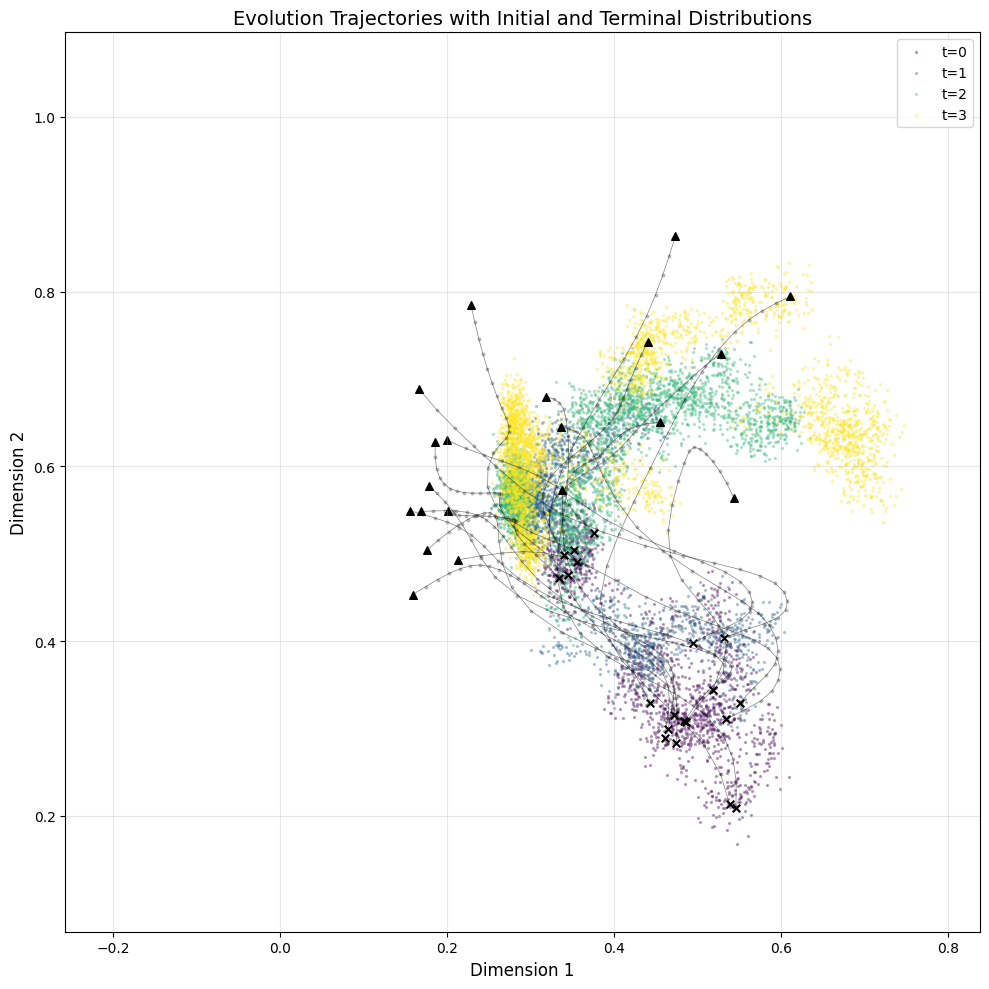

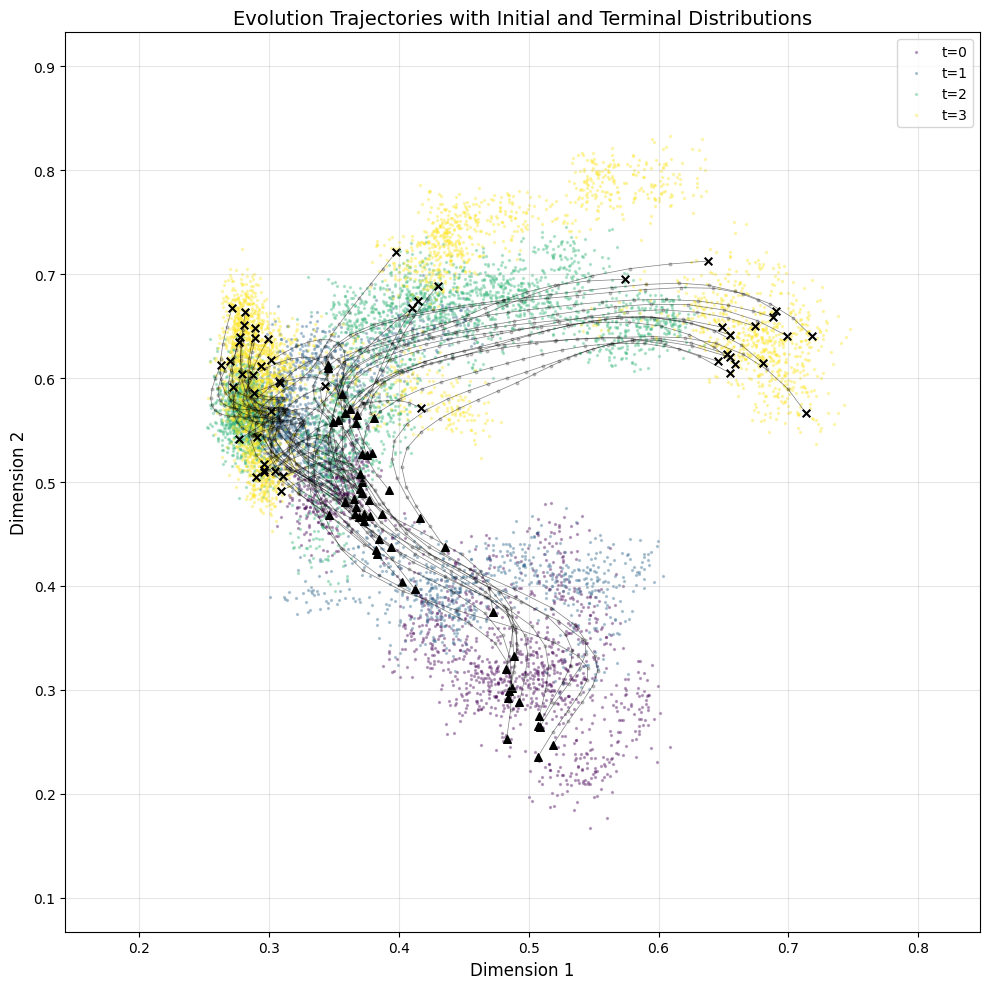

In [162]:
import matplotlib.pyplot as plt
import numpy as np
from src.plot import plot_trajectory_and_distribution
# Convert tensors to numpy if needed
data_train = [d.cpu().numpy() if torch.is_tensor(d) else d for d in primary_data]
all_samples = all_samples.cpu().numpy() if torch.is_tensor(all_samples) else all_samples

# Create visualization
plot_trajectory_and_distribution(data_train, all_samples_forward.cpu().numpy(), n_trajectories=20)
plot_trajectory_and_distribution(data_train, all_samples_backward.cpu().numpy(), n_trajectories=50)

In [163]:



secondary_space= load_source_data(args.sync_data_path, args.time_labels, args.support_points)
# record the number of samples in each group
secondary_space = secondary_space 
lengths_secondary = [data.shape[0] for data in secondary_space]

# concatenate and normaliz

total_secondary = torch.cat(secondary_space, dim=0)
total_secondary, norm_params = normalize_to_unit_cube(total_secondary)

# split back according to the recorded lengths
split_points = torch.cumsum(torch.tensor(lengths_secondary), dim=0).tolist()
start = 0
normalized_data = []

for end in split_points:
    normalized_data.append(total_secondary[start:end])
    start = end

# update primary_data to the normalized data
secondary_data = normalized_data 

Data type: <class 'numpy.lib.npyio.NpzFile'>
Available keys in npz file: ['time1', 'time2', 'time3', 'time4']
time point time1 data shape: torch.Size([1430, 5])
time point time2 data shape: torch.Size([1920, 5])
time point time3 data shape: torch.Size([3103, 5])
time point time4 data shape: torch.Size([3547, 5])


In [164]:
import torch
import torch.nn.functional as F

def map_to_nearest_manifold_multi_space(
    traj_points,
    support_points_main,
    support_points_aux,
    k=10,
    alpha_main=100.0,
    sigma_aux=0.05
):
    """
    Multi-space KNN mapping with softmin weights and time continuity.

    Args:
        traj_points: (T, N, D)
        support_points_main: (M, D)
        support_points_aux: (M, D)
        k: number of neighbors
        alpha_main: softmin temperature for main space
        sigma_aux: bandwidth for auxiliary space

    Returns:
        indices: (T, N, k)
        joint_weights: (T, N, k)
    """
    traj_points = traj_points.to(dtype=support_points_main.dtype)
    T, N, D = traj_points.shape
    M = support_points_main.shape[0]

    traj_points_flat = traj_points.reshape(-1, D)

    # ============================
    # Step 1: 路径索引（考虑时间连续性）
    # ============================
    prev_indices = None
    best_indices_list = []

    for t in range(T):
        traj_t = traj_points[t]

        # 计算当前时间步到 support 的距离
        dist_matrix_t = torch.cdist(traj_t, support_points_main)  # (N, M)
        distances_t, knn_indices_t = torch.topk(dist_matrix_t, k=k, dim=1, largest=False)  # (N, k)

        # 主空间 Gaussian 权重
        kernel_main = torch.exp(-distances_t ** 2 * alpha_main)
        kernel_main = kernel_main / (kernel_main.sum(dim=1, keepdim=True) + 1e-8)

        if t == 0:
            # 第一帧：直接取权重最大的点
            best_indices = knn_indices_t[torch.arange(N), torch.argmax(kernel_main, dim=1)]
            best_indices_list.append(best_indices)
            prev_indices = best_indices
            continue

        # 时间连续性辅助空间权重
        prev_mapped_points = support_points_aux[prev_indices]  # (N, D)
        neighbor_points_aux = support_points_aux[knn_indices_t]  # (N, k, D)
        prev_expanded = prev_mapped_points.unsqueeze(1)  # (N, 1, D)
        distances_aux = torch.norm(neighbor_points_aux - prev_expanded, dim=-1)  # (N, k)
        mask = (torch.abs(neighbor_points_aux - prev_expanded) <= 0.1).all(dim=-1).float()

        kernel_aux = torch.exp(-distances_aux ** 2 / (2 * 0.05 ** 2))  # sigma_time 固定为 0.05
        kernel_aux = kernel_aux * mask
        kernel_aux = torch.clamp(kernel_aux, min=1e-4)

        joint_kernel =  kernel_aux 
        joint_kernel = joint_kernel / (joint_kernel.sum(dim=1, keepdim=True) + 1e-8)

        best_indices = knn_indices_t[torch.arange(N), torch.argmax(joint_kernel, dim=1)]
        best_indices_list.append(best_indices)

        prev_indices = best_indices

    # 路径索引，后面继续批量处理
    path_indices = torch.stack(best_indices_list, dim=0)  # (T, N)

    # ============================
    # Step 2: 高效批量计算 (批处理)
    # ============================
    dist_matrix_support = torch.cdist(support_points_main, support_points_main)  # (M, M)
    distances_main_support, support_knn_indices = torch.topk(dist_matrix_support, k=k, dim=1, largest=False)

    mapped_support_indices = path_indices.view(T * N)
    neighbor_indices = support_knn_indices[mapped_support_indices]  # (T*N, k)

    neighbor_points_main = support_points_main[neighbor_indices]  # (T*N, k, D)
    neighbor_points_aux = support_points_aux[neighbor_indices]    # (T*N, k, D)

    traj_points_expanded = traj_points_flat.unsqueeze(1)  # (T*N, 1, D)

    distances_main = torch.norm(traj_points_expanded - neighbor_points_main, dim=-1)  # (T*N, k)

    # Softmin 权重
    kernel_main = F.softmin(distances_main * alpha_main, dim=1)

    barycenter_aux = neighbor_points_aux.mean(dim=1, keepdim=True)  # (T*N, 1, D)
    distances_aux = torch.norm(neighbor_points_aux - barycenter_aux, dim=-1)  # (T*N, k)

    kernel_aux = torch.exp(-distances_aux ** 2 / (2 * sigma_aux ** 2))
    kernel_aux = torch.clamp(kernel_aux, min=1e-4)

    joint_kernel = kernel_main * kernel_aux
    joint_kernel = joint_kernel / (joint_kernel.sum(dim=1, keepdim=True) + 1e-8)

    indices = neighbor_indices.view(T, N, k)
    joint_weights = joint_kernel.view(T, N, k)

    return indices, joint_weights

In [165]:
import torch
import torch.nn.functional as F
from src.MapSpace import map_whole_trajectory2another_manifold, smooth_trajectory      



time_length = all_samples_backward.shape[0]
z_t_samples_backward_torch = torch.tensor(all_samples_backward)
print(z_t_samples_backward_torch.shape)

print("time_length: ", time_length)
primary_local_list = []
mapped_mainfold_list = []
error_list = []
print("z_t_samples_backward_torch ", z_t_samples_backward_torch[0])
print(z_t_samples_backward_torch.shape)
print("total_primal.shape: ", total_primal.shape)
print("total_secondary.shape: ", total_secondary.shape)

mapped_indices, weights = map_to_nearest_manifold_multi_space(
    z_t_samples_backward_torch,  # (N, Sample, dim)
    total_primal,
    total_secondary,
    k=30,
    alpha_main=5,
    sigma_aux=0.5
)
print("mapped_indices.shape: ", mapped_indices.shape)
print("weights.shape: ", weights.shape)

for i in range(time_length):
    if i == 0:
        top_index = torch.argmax(weights[i], dim=1)
        selected_indices = mapped_indices[i][torch.arange(mapped_indices[i].size(0)), top_index]
        mapped_mainfold = total_secondary[selected_indices].cpu()
    else:
        mapped_secondary = total_secondary[mapped_indices[i]].cpu()
        mapped_mainfold = torch.sum(mapped_secondary.cpu() * weights[i].cpu().unsqueeze(-1), dim=1)
        mapped_mainfold_list.append(mapped_mainfold)


mapped_mainfold_trajectory = torch.stack(mapped_mainfold_list, dim=0)  # (N, Sample, dim)
print("mapped_mainfold_trajectory.shape: ", mapped_mainfold_trajectory.shape)


secondary_data = [data.to('cpu') for data in secondary_data] 

torch.Size([21, 8000, 5])
time_length:  21
z_t_samples_backward_torch  tensor([[0.2828, 0.5926, 0.3410, 0.4994, 0.3500],
        [0.2931, 0.5687, 0.3505, 0.5065, 0.3364],
        [0.2734, 0.5801, 0.3482, 0.5543, 0.3798],
        ...,
        [0.3191, 0.5205, 0.7007, 0.5505, 0.5091],
        [0.3168, 0.5281, 0.6894, 0.5616, 0.5559],
        [0.3174, 0.5082, 0.7304, 0.5966, 0.5675]], device='cuda:0')
torch.Size([21, 8000, 5])
total_primal.shape:  torch.Size([10000, 5])
total_secondary.shape:  torch.Size([10000, 5])
mapped_indices.shape:  torch.Size([21, 8000, 30])
weights.shape:  torch.Size([21, 8000, 30])


/home/jfwang/media/jfwang/Cursor/tmp/ipykernel_329420/3688752055.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  z_t_samples_backward_torch = torch.tensor(all_samples_backward)


mapped_mainfold_trajectory.shape:  torch.Size([20, 8000, 5])


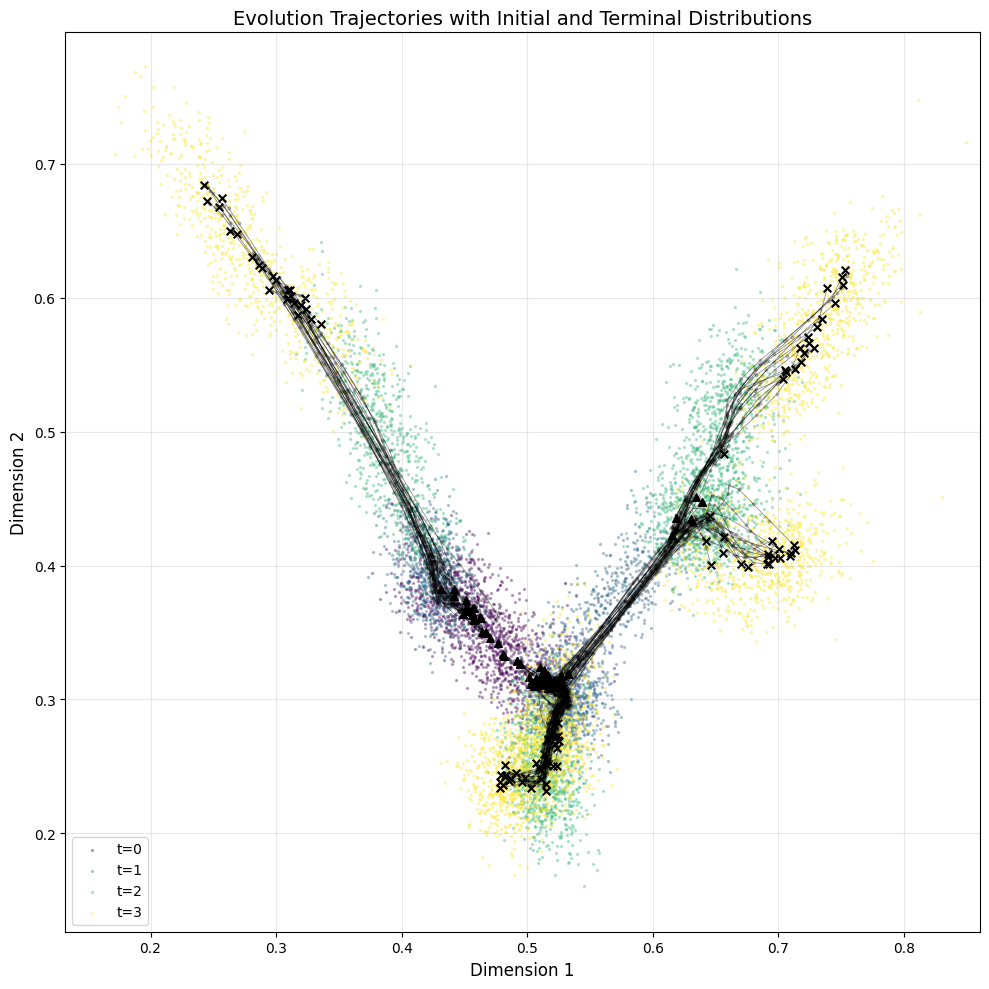

In [166]:
def gaussian_kernel(window_size=5, std=1.0, device=torch.device("cuda:0")):
    center = window_size // 2
    x = torch.arange(window_size, device=device) - center
    kernel = torch.exp(-0.5 * (x / std)**2)
    kernel = kernel / kernel.sum()
    return kernel.view(1, 1, -1)  # shape (1, 1, window_size)
import torch.nn.functional as F

def smooth_trajectory(trajectory, window_size=5):
    """
    Smooth the trajectory (keep the first and last frame unchanged), support efficient vectorization.
    
    Args:
        trajectory: (N_time, Sample, dim)
        window_size: odd, window size

    Returns:
        smoothed: (N_time, Sample, dim)
    """
    assert window_size % 2 == 1, "window_size must be odd."
    N_time, Sample, dim = trajectory.shape
    half_w = window_size // 2

    # 1. reshape: (Sample * dim, N_time)
    traj = trajectory.permute(1, 2, 0).reshape(Sample * dim, N_time).unsqueeze(1)  # (Batch, 1, Time)

    # 2. padding: keep boundary
    traj_padded = F.pad(traj, pad=(half_w, half_w), mode='replicate')  # (Batch, 1, Time + pad)

    # 3. Gaussian kernel
    kernel = gaussian_kernel(window_size=window_size, std=2.0, device=trajectory.device)

    # 4. Apply convolution
    smoothed = F.conv1d(traj_padded, kernel, groups=1)  # (Batch, 1, Time)

    # 5. Reshape back
    smoothed = smoothed.squeeze(1).reshape(Sample, dim, N_time).permute(2, 0, 1).contiguous()  # (N_time, Sample, dim)

    # 6. Force boundary unchanged
    smoothed[0] = trajectory[0]
    smoothed[-1] = trajectory[-1]

    return smoothed

smoothed_trajectory = smooth_trajectory(mapped_mainfold_trajectory, window_size=5)

plot_trajectory_and_distribution(secondary_data, smoothed_trajectory.cpu().numpy(), n_trajectories=100)

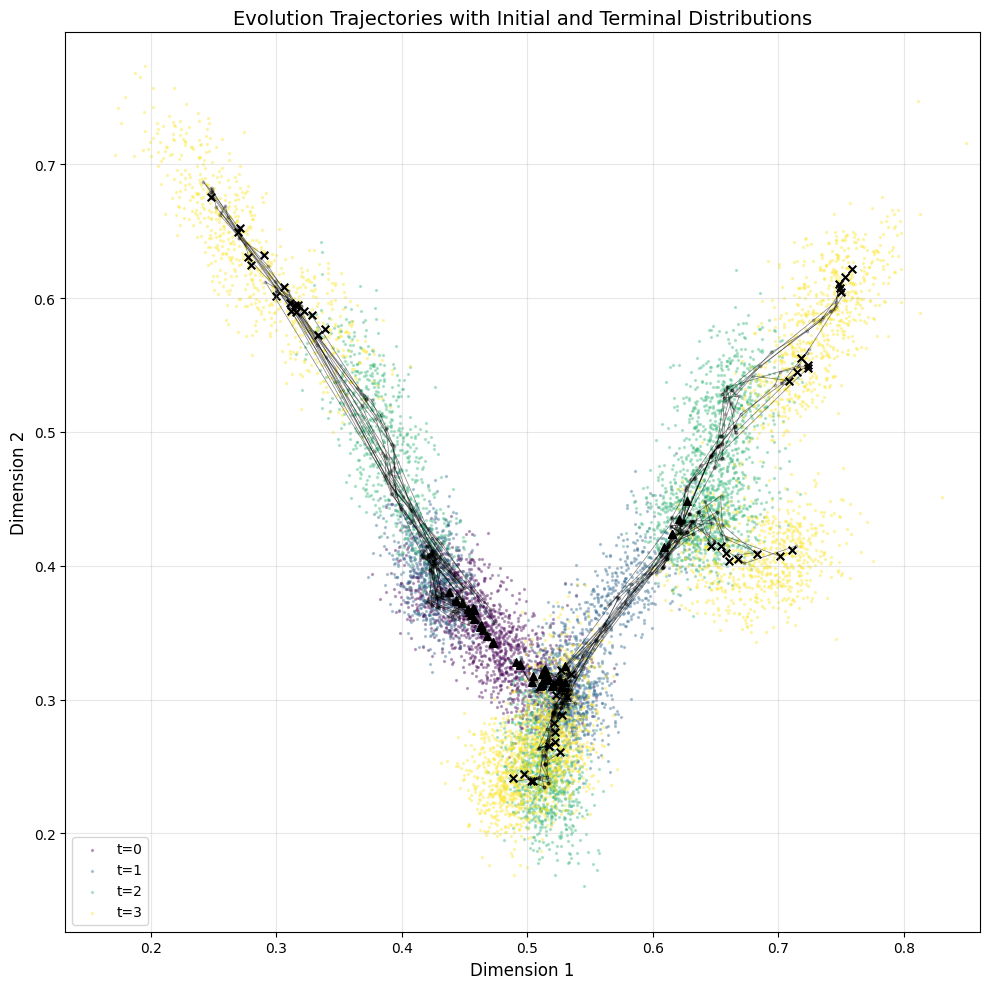

In [167]:
plot_trajectory_and_distribution(secondary_data, mapped_mainfold_trajectory.cpu().numpy(), n_trajectories=50)

In [168]:
'''
from src.plot import visualize_evolution
reverse_trajectory = torch.flip(smoothed_trajectory, dims=[0])
visualization = visualize_evolution(
    reverse_trajectory, 
    terminal_samples=secondary_data[-1],
    save_path='evolution_animation_2nd_reconstruction.gif', 
    fps=10, 
    dpi=100  
)
display(visualization)
'''

"\nfrom src.plot import visualize_evolution\nreverse_trajectory = torch.flip(smoothed_trajectory, dims=[0])\nvisualization = visualize_evolution(\n    reverse_trajectory, \n    terminal_samples=secondary_data[-1],\n    save_path='evolution_animation_2nd_reconstruction.gif', \n    fps=10, \n    dpi=100  \n)\ndisplay(visualization)\n"

In [169]:

from src.DataLoad import denormalize_from_unit_cube 
import joblib
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

normalized_primal = total_primal

norm_params = torch.load('primal_norm_params.pt', map_location='cpu')
denormalized_primal = denormalize_from_unit_cube(normalized_primal.cpu(), norm_params)

'''
pca_loaded = joblib.load('pca_model_RNA.pkl')
dePCA_primal = pca_loaded.inverse_transform(denormalized_primal)
dePCA_smoothed_trajectory_flat = pca_loaded.inverse_transform(denormalized_smoothed_trajectory_flat)
'''

#print(dePCA_primal.shape)
#print(dePCA_smoothed_trajectory_flat.shape)


umap_model = joblib.load('FiveBranch_umap_model.pkl')
umap_primal = umap_model.transform(denormalized_primal)



umap_trajectory = []
for i in range(viz_timesteps):
    sample_slice =  all_samples_backward[i]
    denormalized_sample_slice = denormalize_from_unit_cube(sample_slice.cpu(), norm_params)
    umap_sample_slice = umap_model.transform(denormalized_sample_slice)
    umap_trajectory.append(umap_sample_slice)

umap_trajectory_array = np.array(umap_trajectory)
umap_trajectory_torch = torch.tensor(umap_trajectory_array, dtype=torch.float32)
umap_smoothed_trajectory = smooth_trajectory(umap_trajectory_torch, window_size=5)




[    0    40    80   120   160   200   240   280   320   360   400   440
   480   520   560   600   640   680   720   760   800   840   880   920
   960  1000  1040  1080  1120  1160  1200  1240  1280  1320  1360  1400
  1440  1480  1520  1560  1600  1640  1680  1720  1760  1800  1840  1880
  1920  1960  2000  2040  2080  2120  2160  2200  2240  2280  2320  2360
  2400  2440  2480  2520  2560  2600  2640  2680  2720  2760  2800  2840
  2880  2920  2960  3000  3040  3080  3120  3160  3200  3240  3280  3320
  3360  3400  3440  3480  3520  3560  3600  3640  3680  3720  3760  3800
  3840  3880  3920  3960     0   -40   -80  -120  -160  -200  -240  -280
  -320  -360  -400  -440  -480  -520  -560  -600  -640  -680  -720  -760
  -800  -840  -880  -920  -960 -1000 -1040 -1080 -1120 -1160 -1200 -1240
 -1280 -1320 -1360 -1400 -1440 -1480 -1520 -1560 -1600 -1640 -1680 -1720
 -1760 -1800 -1840 -1880 -1920 -1960 -2000 -2040 -2080 -2120 -2160 -2200
 -2240 -2280 -2320 -2360 -2400 -2440 -2480 -2520 -2

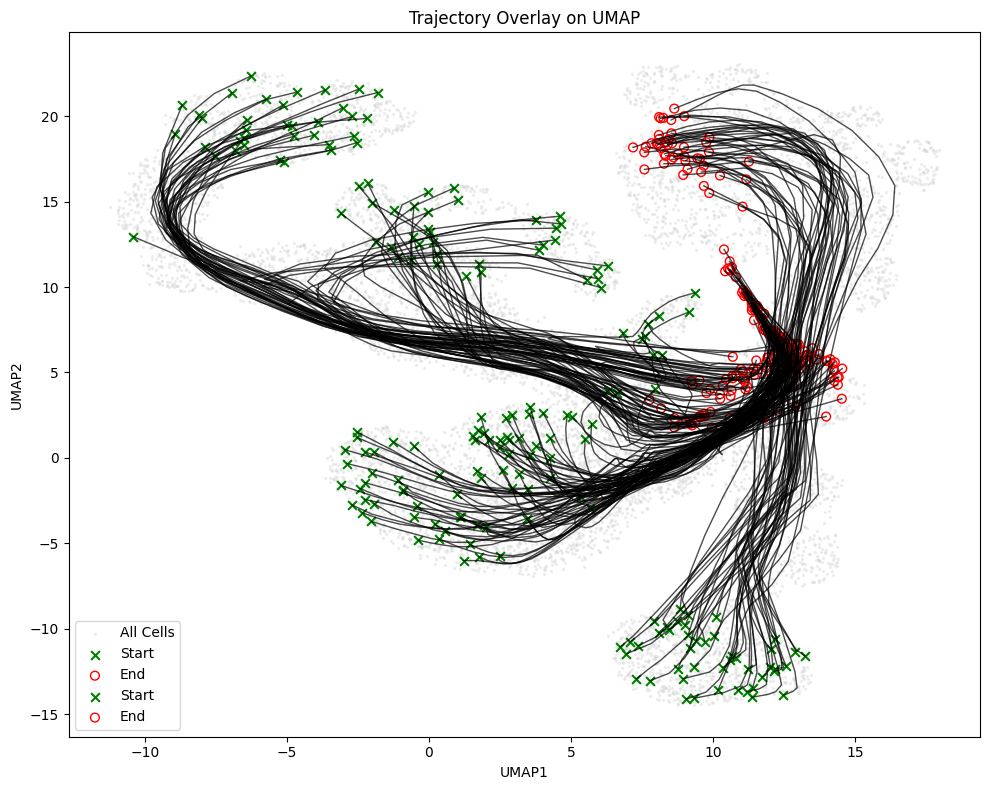

In [170]:
import matplotlib.pyplot as plt
import numpy as np



#chosen_indices = np.random.choice(all_indices, size=num_paths_to_show, replace=False)

sampled_indices = chosen_indices[::40]
print(sampled_indices)


plt.figure(figsize=(10, 8))


plt.scatter(
    umap_primal[:, 0], umap_primal[:, 1],
    s=2, alpha=0.3, color='lightgray', label='All Cells'
)


# 绘制每条轨迹
for idx in sampled_indices:
    traj = umap_smoothed_trajectory.cpu().numpy()[:, idx, :]  # shape: (timesteps, 2)

    # 画中间轨迹点（黑色）
    plt.plot(traj[:, 0], traj[:, 1], color='black', linewidth=1, alpha=0.7)

    # 起点（X）
    plt.scatter(traj[0, 0], traj[0, 1], marker='x', color='green', s=40, label='Start' if idx == chosen_indices[0] else "")

    # 终点（O）
    plt.scatter(traj[-1, 0], traj[-1, 1], marker='o', facecolors='none', edgecolors='red', s=40, label='End' if idx == chosen_indices[0] else "")


# ---------------------
# 图例 & 美化
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('Trajectory Overlay on UMAP')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist

def neighbor_distance_transfer(rna_points, atac_points, n_neighbors=5, plot=True):
    """
    For each point in rna_points, find its n_neighbors nearest neighbors in RNA space,
    then compute the mean pairwise distance among these neighbors in ATAC space.
    
    Args:
        rna_points: numpy array, shape (n_cells, n_features)
        atac_points: numpy array, shape (n_cells, n_features), must correspond to rna_points
        n_neighbors: int, number of neighbors to consider (default 5)
        plot: bool, whether to plot the result in RNA PCA space (default True)
        
    Returns:
        mean_atac_distances: numpy array, shape (n_cells,), mean pairwise ATAC distance for each cell's RNA neighbors
    """
    n_cells = rna_points.shape[0]
    mean_atac_distances = np.zeros(n_cells)
    
    # Find neighbors in RNA space
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1, algorithm='auto').fit(rna_points)
    # +1 because the closest neighbor is itself
    distances, indices = nbrs.kneighbors(rna_points)
    
    for i in range(n_cells):
        neighbor_idx = indices[i][1:]  # Exclude itself
        atac_neighbors = atac_points[neighbor_idx]
        # Compute all pairwise distances among these neighbors in ATAC space
        pairwise_dist = pdist(atac_neighbors, metric='euclidean')
        mean_atac_distances[i] = pairwise_dist.mean()
    
    # Visualization
    if plot:
        plt.figure(figsize=(8,6))
        sc = plt.scatter(rna_points[:,0], rna_points[:,1], c=mean_atac_distances, cmap='viridis', s=5)
        plt.xlabel('RNA PC1')
        plt.ylabel('RNA PC2')
        plt.title('Mean ATAC Distance of RNA Nearest Neighbors')
        cbar = plt.colorbar(sc)
        cbar.set_label('Mean ATAC Distance')
        plt.tight_layout()
        plt.show()
    
    return mean_atac_distances

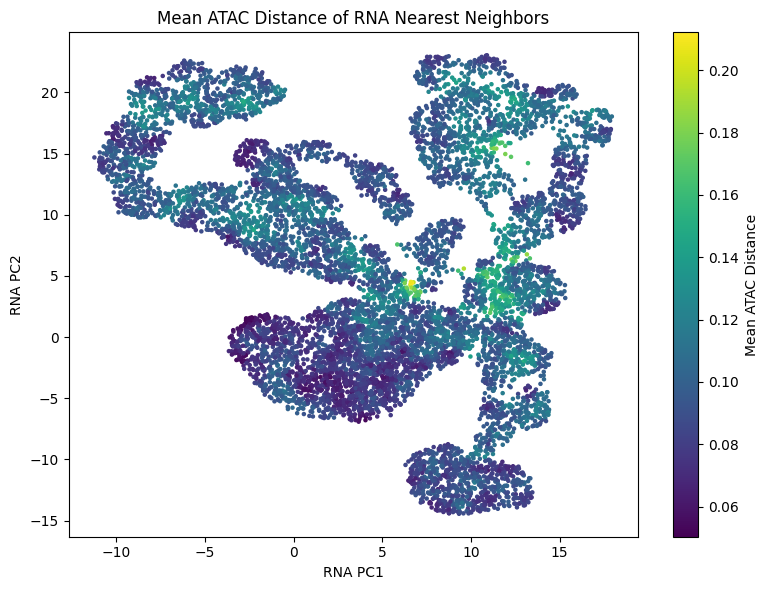

In [172]:
mean_dist = neighbor_distance_transfer(umap_primal, total_primal.cpu(), n_neighbors=20, plot=True)